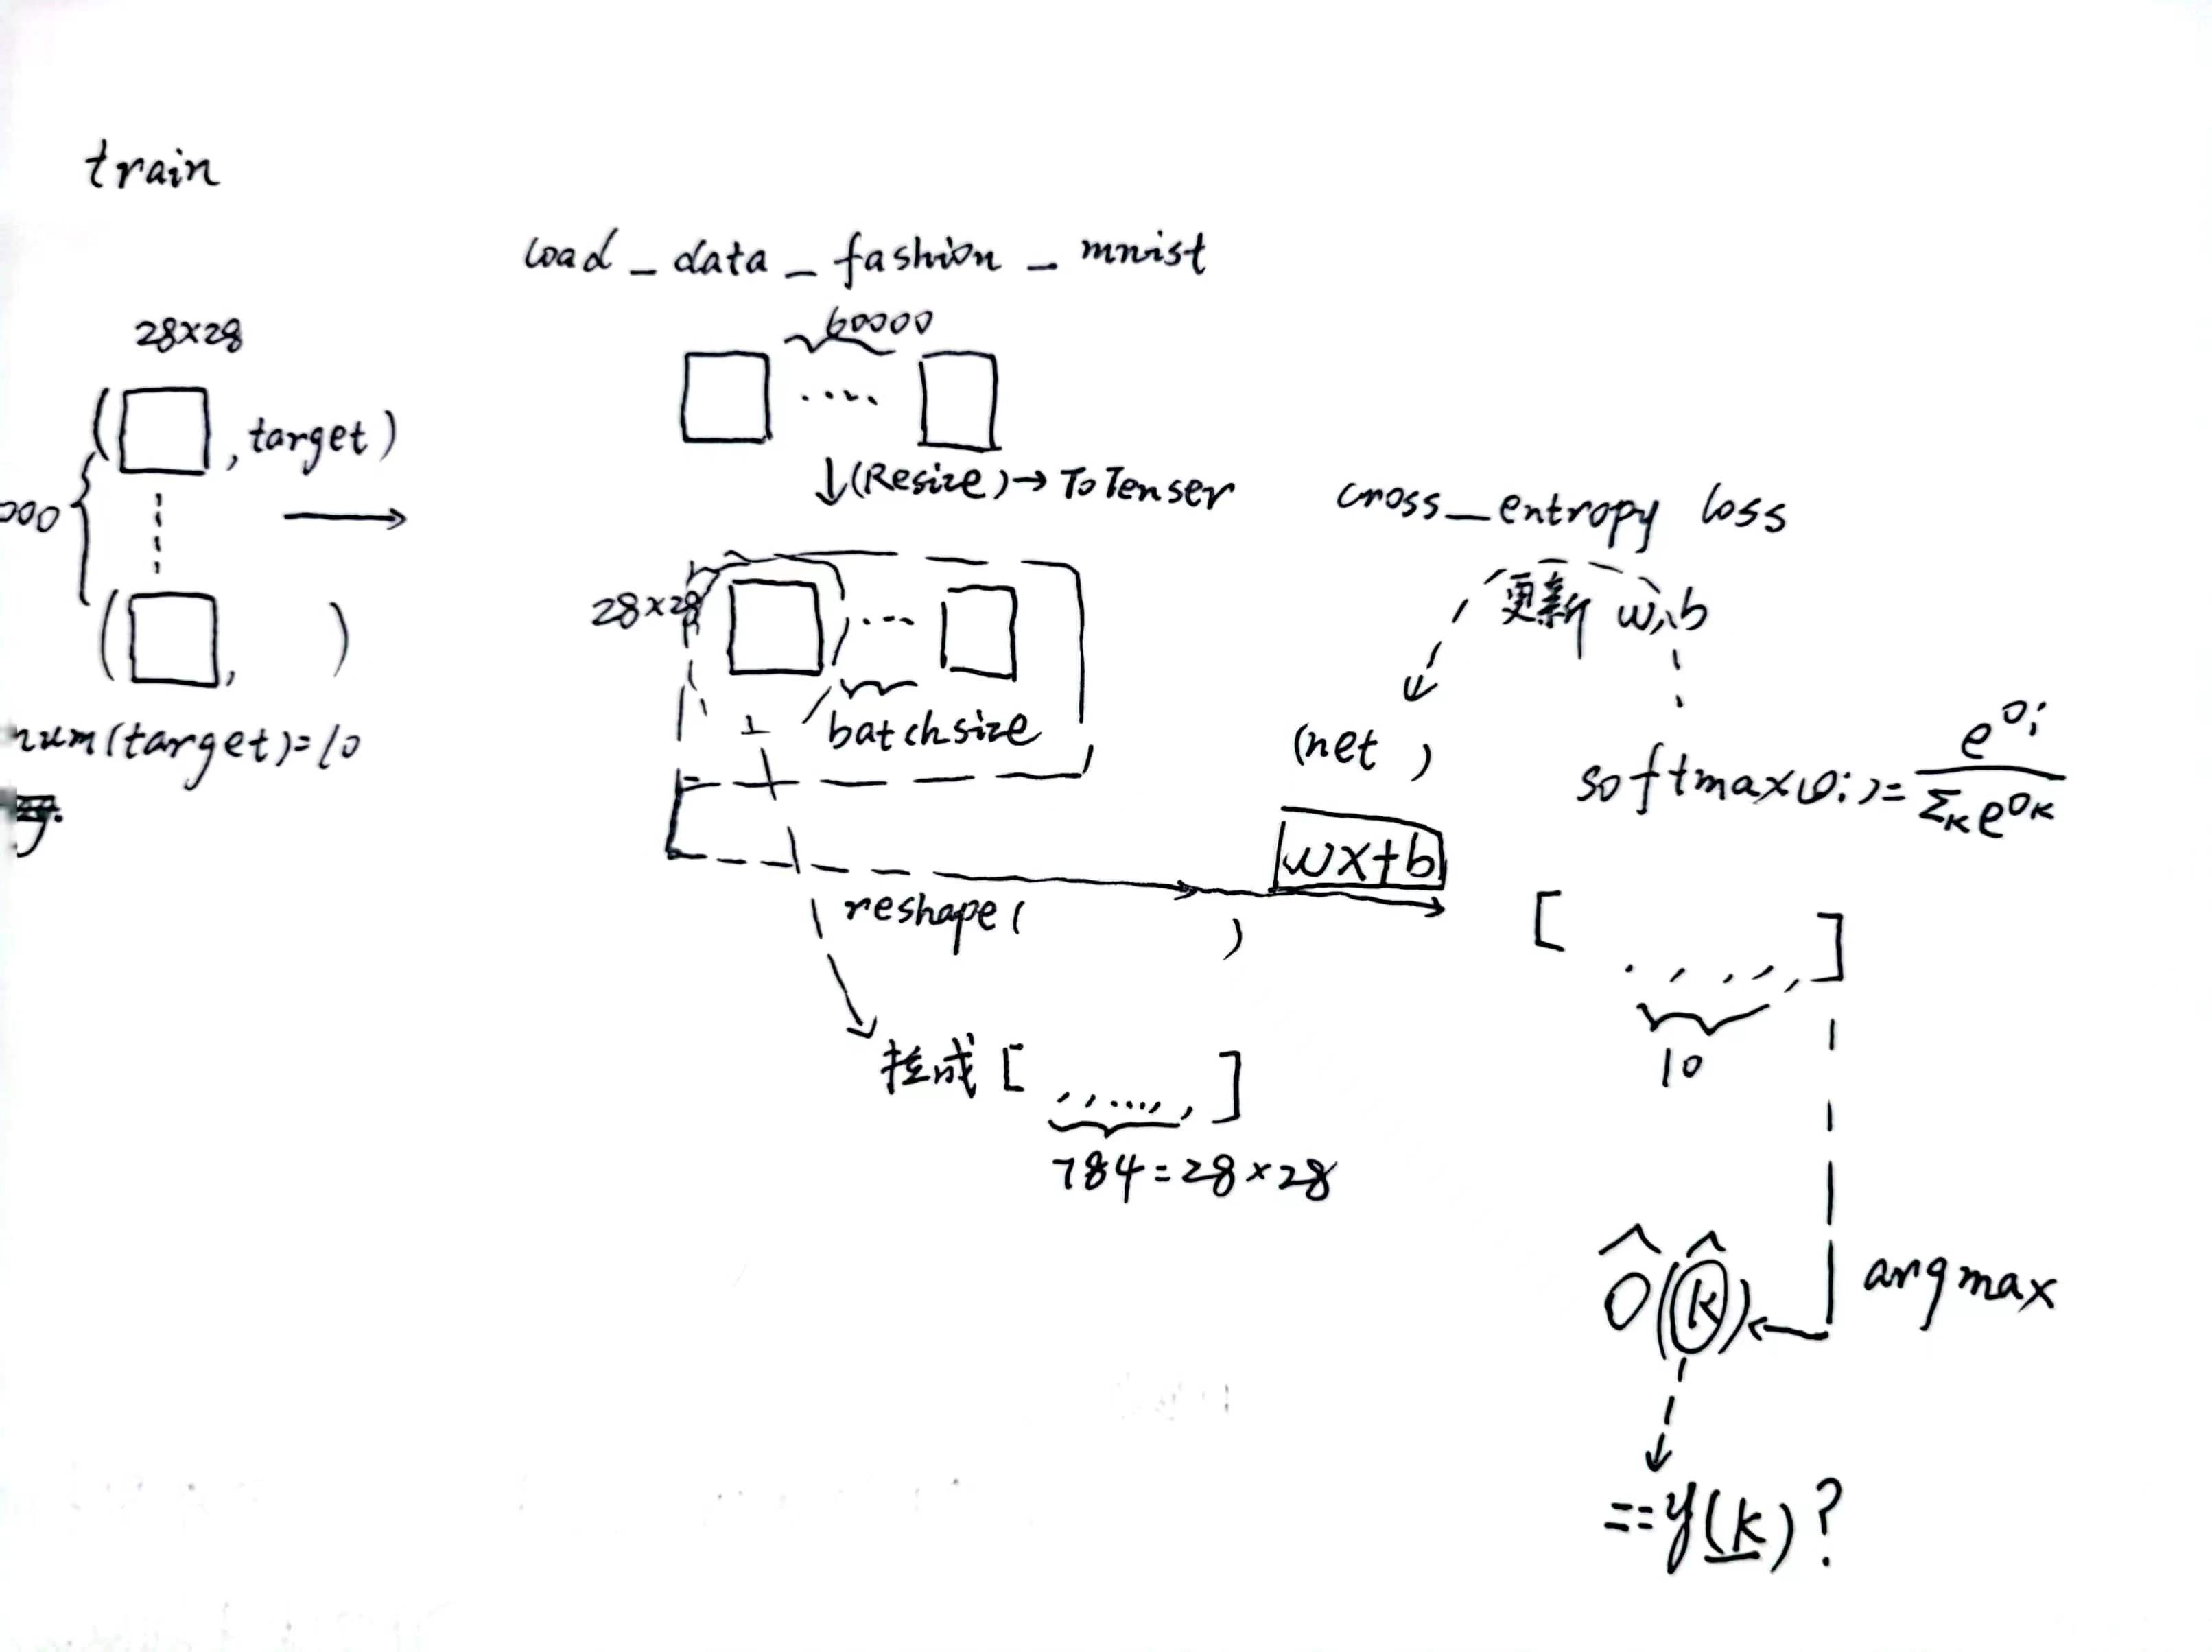

In [2]:
import d2l_tools as d2l
import torch
from IPython import display # 绘制动态图
import matplotlib.pyplot as plt

获取fashion_mnist数据集

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
for x, y in train_iter:
    print(x.type,y.type)
    break

<built-in method type of Tensor object at 0x000002031A800C70> <built-in method type of Tensor object at 0x000002031A800C20>


初始化模型参数

展平每个图像，把它们看作长度为784的向量。暂时只把每个像素位置看作一个特征（线性变换）

In [3]:
num_inputs = 28 * 28
num_outputs = 10
# 784个像素点在 w 变换后成为 10个类别
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

定义Softmax操作
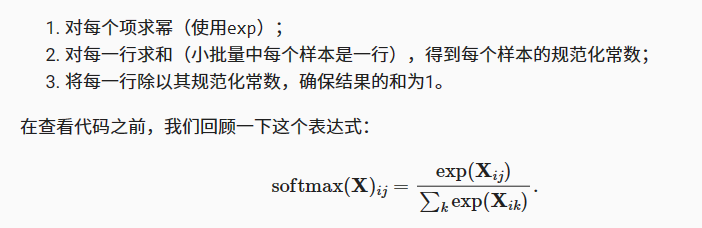

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    # 考虑到 X 为 batch_size 个 向量组成
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition # 广播机制

In [5]:
# 测试
x = torch.randn(2,5)
x_prob = softmax(x)
x_prob,x_prob.sum(1)

(tensor([[0.1034, 0.0589, 0.5649, 0.1765, 0.0964],
         [0.1185, 0.3790, 0.0398, 0.0527, 0.4100]]),
 tensor([1., 1.]))

定义模型

In [6]:
# linear_regression + softmax
def net(x):
    # n * 784   784 * 10 ---> n * 10 
    return softmax(torch.matmul(x.reshape(-1,w.shape[0]), w) + b)

定义损失函数
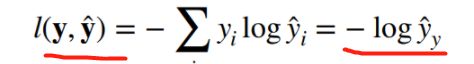

In [7]:
# 交叉熵
"""
我们创建一个数据样本y_hat，其中包含2个样本在3个类别的预测概率 
以及它们对应的标签y。 
有了y，我们知道在第一个样本中，第一类是正确的预测； 
而在第二个样本中，第三类是正确的预测。 

"""
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])
y_hat[[0,1]],y_hat[[0,1], y]

(tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([0.1000, 0.5000]))

In [8]:
def cross_entropy(y_hat, y): 
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

分类精度

即正确预测数量与总预测数量之比
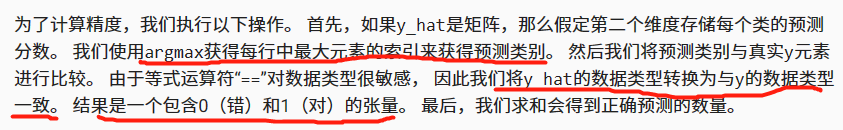

In [1]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 每个样本中选出概率最大的类别,argmax返回最大值的索引
        y_hat = y_hat.argmax(axis=1)
    
    cmp = y_hat.type(y.dtype) == y
    # 返回正确的总数
    return float(cmp.type(y.dtype).sum())
    """
    QA:为什么在此处不除以len(y)呢？
    Answer: 因为最后一个batch_size可能没满;因此总准确数再除以总样本数更好
    
    """

In [10]:
accuracy(y_hat, y) / len(y), accuracy(y_hat, y)

(0.5, 1.0)

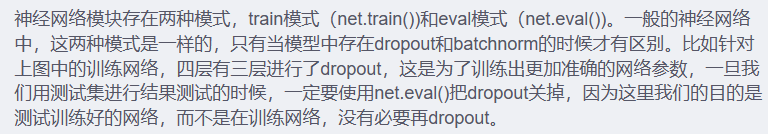

In [11]:
def evaluate_accuracy(net, data_iter): 
    # 计算指定数据集上的模型精度
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for x, y in data_iter:
            metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]

In [12]:
class Accumulator: 
    # 在多个变量进行累加
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [13]:
evaluate_accuracy(net, test_iter)

0.0754

训练

updater是更新模型参数的常用函数，它接受批量大小作为参数。

它可以是d2l.sgd函数，也可以是框架的内置优化函数
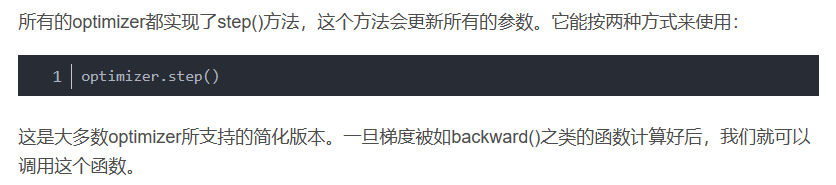

In [14]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 训练模型
    # 若为torch.nn.Module内置网络，则把模式设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和，训练准确度总和，样本数
    metric = Accumulator(3)
    for x, y in train_iter:
        y_hat = net(x)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用自定义的优化器和损失函数
            l.sum().backward()
            updater(x.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [15]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

In [16]:
# 动画中绘制数据
class Animator: 
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5,2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
# 可视化训练进度
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #
    animator = Animator(xlabel='epoch', xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1, train_metrics + (test_acc, ))
    
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc

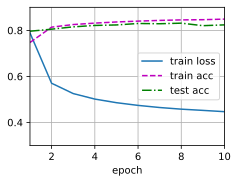

In [18]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

预测

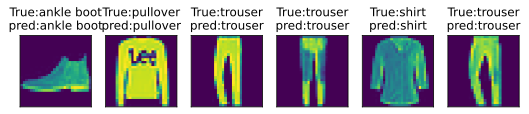

In [19]:
# 预测并展示部分结果
def predict_ch3(net, test_iter, n=6):
    # 只查看一组
    for x, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(x).argmax(axis=1))
    titles = ["True:" + true + "\n" + "pred:" + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        x[0:n].reshape((n, 28, 28)), 1, n, titles=titles)
    
predict_ch3(net, test_iter)

***练习***
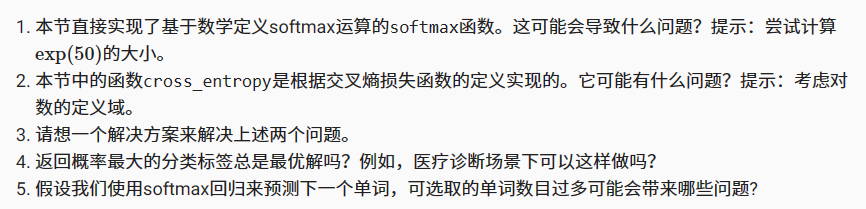

In [20]:
# QA1 : 存在溢出(有噪声，网络参数初始化没弄好之类的)
torch.exp(torch.tensor([100]))

tensor([inf])

In [21]:
# QA2 : 当p很小时，-log(p)可能溢出
def cross_entropy(y_hat, y): 
    return -torch.log(y_hat[range(len(y_hat)), y])
"""

考虑一种情况，
y_hat : torch([[1e-100, 0.2, 0.8 - 1e-100], 
                [0.2, 0.0001, 0.7999]]
                )
y : torch([0,1])

"""
# 测试
y_hat = torch.tensor([[1e-100, 0.2, 0.8 - 1e-100], 
                      [0.2, 0.0001, 0.7999]]
                    )
y = torch.tensor([0,1])
cross_entropy(y_hat, y)

tensor([   inf, 9.2103])

QA3 思路一: softmax改进 x --- > x - max(x)

In [22]:
def softmax_improve(x):
    x_exp = torch.exp(x - x.max(1,keepdim=True)[0])
    if len(x.shape) > 1:
        partition = x_exp.sum(1,keepdim=True)
    else:
        partition = x_exp.sum()
    return x_exp / partition

In [23]:
x = torch.tensor([[100,1,3],[20,10,99]])
softmax_improve(x)

tensor([[1.0000e+00, 1.0089e-43, 7.4689e-43],
        [4.9061e-35, 2.2274e-39, 1.0000e+00]])

In [24]:
# 但是仍然存在问题
x = torch.tensor([[1000,2,6]])
softmax_improve(x)
# cross_entropy中可能出现溢出

tensor([[1., 0., 0.]])

QA4

在医疗场景中，比如通过照片判断疾病类别，概率最大的分类标签不一定是最优解，需要具体问题，具体分析。

QA5

当可选单词过于多，而神经网络参数学习效果不佳时，可能每个分类的概率较平均，成为随机选择分类。

对于QA1,QA2,QA3的一种可行方法

In [9]:
def softmax_improve(x):
    x_exp = torch.exp(x - x.max(1,keepdim=True)[0])
    if len(x.shape) > 1:
        partition = x_exp.sum(1,keepdim=True)
    else:
        partition = x_exp.sum()
    return x_exp / partition

In [26]:
torch.inf > torch.tensor([1e10])

tensor([True])

In [27]:
torch.log(torch.tensor(1e-45)), torch.log(torch.tensor(1e-46))
# entropy_loss 设置一个上限

(tensor(-103.2789), tensor(-inf))

In [28]:
def cross_entropy_improve(y_hat, y):
    tmp = -torch.log(y_hat[range(len(y_hat)), y])
    return torch.where(tmp > 104, 104, tmp)

In [35]:
y_hat = torch.tensor([[1e-46, 0.5, 0.5 - 1e-46],[1e-20, 0.6, 0.4 - 1e-20]])
y = torch.tensor([0])
loss = cross_entropy_improve(y_hat, y)
loss

tensor([104.0000,  46.0517])

很棒的一个方法：
LSE

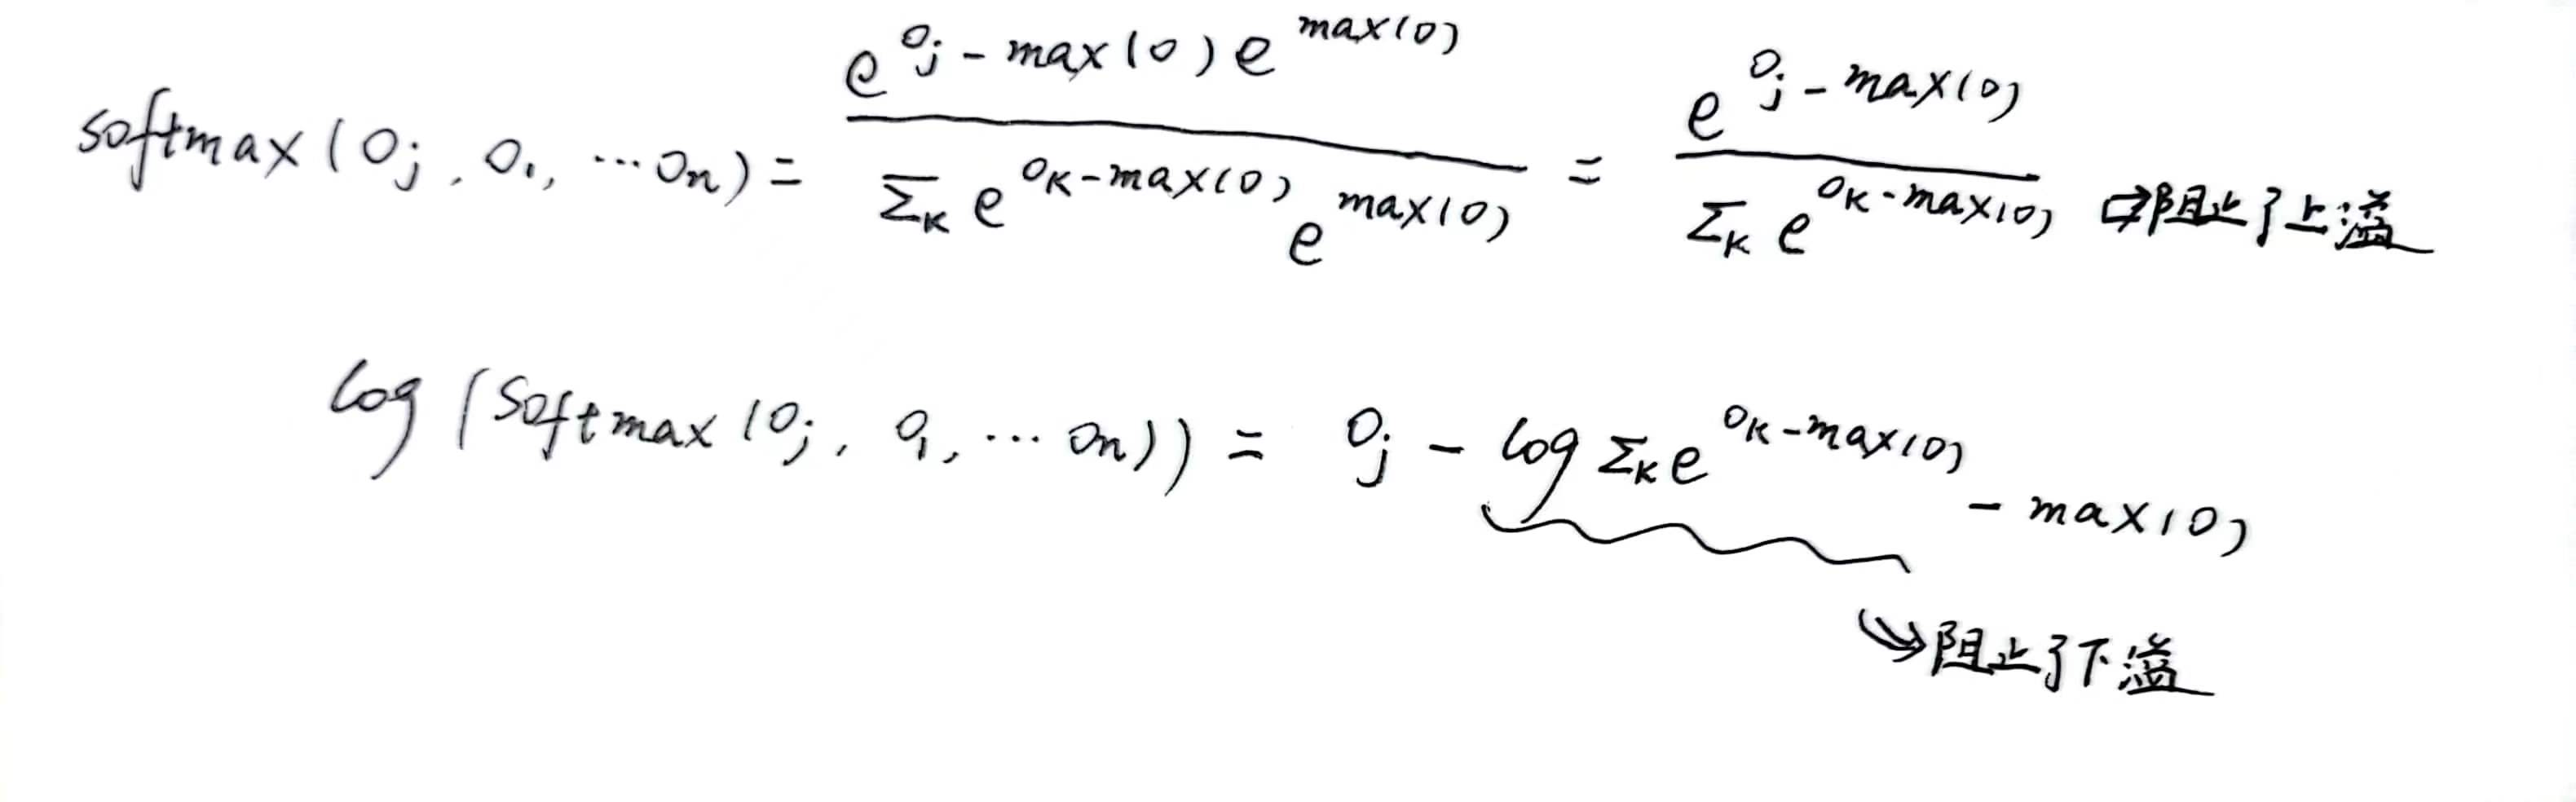

In [16]:
def CrossEntropyLoss(y_hat, y):
    soft_tmp = softmax_improve(y_hat)
    LSE = y_hat - y_hat.max(1,keepdim=True)[0] - torch.log(torch.exp(y_hat - y_hat.max(1,keepdim=True)[0]).sum(1,keepdim=True))
    return -LSE[range(len(LSE)), y]

In [17]:
from torch import nn
loss = nn.CrossEntropyLoss(reduction="none")

In [20]:
# 测试
y_hat = torch.tensor([[10000.0,20,60], [12,60,99]])
y = torch.tensor([0,1])
loss(y_hat, y)

tensor([-0., 39.])

In [21]:
CrossEntropyLoss(y_hat, y)

tensor([-0., 39.])